### Cycle GAN
#### References
- [CycleGAN in Keras](https://keras.io/examples/generative/cyclegan/)
- [Advanced-Deep-Learning-with-Python/Chapter05](https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Python/tree/master/Chapter05/cyclegan)

<a href="https://colab.research.google.com/github/paulaceccon/deep-learning-studies/blob/main/notebooks/generative_models/gans/cycle_gan.ipynb" target="_parent" style="float: left;"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

It's compose of four models, two generators and two discriminators. One of the generators converts images from domain $X$ to $Y$, while the other converts images from domain $Y$ to $X$. The discriminators will determine if the images produced by the generators are convicing.

![Cycle GAN](https://miro.medium.com/max/1400/1*gOk-R94KA11T0B2kOau24w.png)

The generators are judged based on 3 criterias:

1. **Validity**. Do the images produced by each generator fool the relevant discriminator?
2. **Reconstruction**. If we apply the two generators one after the other, do we return to the original image? I.e., $x \rightarrow G_{AB}(a) \rightarrow G_{BA}(G_{AB}(a)) \approx a$.
3. **Identity**. If we aply each generator to images from its own domain, does the image remain unchanged? I.e., $G_{AB}(b) ≈ b$. 

![Cycle GAN Loss](https://raw.githubusercontent.com/yunjey/mnist-svhn-transfer/master/gif/cyclegan.png)

In [1]:

!pip install tensorflow-addons

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime

from tensorflow.keras.layers import Input, Concatenate, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.layers.normalizations import InstanceNormalization
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import array_to_img

import tensorflow_addons as tfa
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
autotune = tf.data.AUTOTUNE

%load_ext tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Load the dataset

In [2]:
def normalize(img):
    img = tf.cast(img, dtype=tf.float32)
    data = (img / 127.5) - 1
    return data

In [3]:
# Load the horse-zebra dataset using tensorflow-datasets.
dataset, _ = tfds.load("cycle_gan/horse2zebra", with_info=True, as_supervised=True)
train_horses, train_zebras = dataset["trainA"], dataset["trainB"]
test_horses, test_zebras = dataset["testA"], dataset["testB"]

In [4]:
# Define the standard image size.
orig_img_size = (286, 286)
# Size of the random crops to be used during training.
input_img_size = (256, 256, 3)

buffer_size = 256
batch_size = 1

In [5]:
def preprocess_image(img, label):
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize(img)
    return img

In [6]:
# Apply the preprocessing operations to the training data
train_horses = (
    train_horses.map(preprocess_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
train_zebras = (
    train_zebras.map(preprocess_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

# Apply the preprocessing operations to the test data
test_horses = (
    test_horses.map(preprocess_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
test_zebras = (
    test_zebras.map(preprocess_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

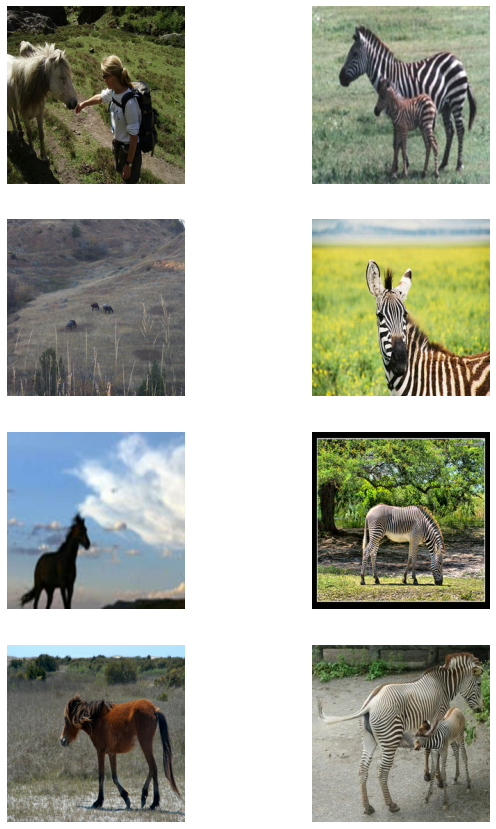

In [7]:
# Visualize some samples
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, samples in enumerate(zip(train_horses.take(4), train_zebras.take(4))):
    horse = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    zebra = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    ax[i, 0].imshow(horse)
    ax[i, 1].imshow(zebra)
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

### Model

In [8]:
def build_generator(img: Input, name: str) -> Model:
    """
    U-Net Generator
    """

    def downsampling2d(layer_input: Input, filters: int):
        """
        Layers used in the encoder.

        Args:
          layer_input: input layer
          filters: number of filters
        """
        d = Conv2D(filters=filters, kernel_size=4, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        d = InstanceNormalization()(d)
        return d

    def upsampling2d(layer_input: Input, skip_input: Input, filters: int):
        """
        Layers used in the decoder

        Args:
          layer_input: input layer
          skip_input: another input from the corresponding encoder block
          filters: number of filters
        """
        u = UpSampling2D(size=2)(layer_input)
        u = Conv2D(filters=filters, kernel_size=4, strides=1, padding='same',
                   activation='relu')(u)
        u = InstanceNormalization()(u)
        u = Concatenate()([u, skip_input])
        return u

    # Encoder
    gf = 32
    d1 = downsampling2d(img, gf)
    d2 = downsampling2d(d1, gf * 2)
    d3 = downsampling2d(d2, gf * 4)
    d4 = downsampling2d(d3, gf * 8)

    # Decoder
    # Note that we concatenate each upsampling2d block with
    # its corresponding downsampling2d block, as per U-net
    u1 = upsampling2d(d4, d3, gf * 4)
    u2 = upsampling2d(u1, d2, gf * 2)
    u3 = upsampling2d(u2, d1, gf)

    u4 = UpSampling2D(size=2)(u3)
    output_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)

    model = Model(img, output_img, name=name)
    model.summary()

    return model

In [9]:
def build_discriminator(img: Input, name: str) -> Model:
    """
    CNN discriminator
    """

    def d_layer(layer_input: Input, filters: int, f_size=4, normalization: bool=True):
        """
        Discriminator layer.

        Args:
          layer_input: input layer
          skip_input: another input from the corresponding encoder block
          filters: number of filters
        """
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if normalization:
            d = InstanceNormalization()(d)
        return d

    df = 64

    d1 = d_layer(img, df, normalization=False)
    d2 = d_layer(d1, df * 2)
    d3 = d_layer(d2, df * 4)
    d4 = d_layer(d3, df * 8)

    validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

    model = Model(img, validity, name=name)
    model.summary()

    return model

In [10]:
class CycleGan(Model):
    def __init__(
        self,
        generator_G: Model,
        generator_F: Model,
        discriminator_X: Model,
        discriminator_Y: Model,
        lambda_cycle: float=10.0,
        lambda_identity: float=0.5,
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = MeanAbsoluteError()
        self.identity_loss_fn = MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    we can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adverserial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Horse to fake zebra
            fake_y = self.gen_G(real_x, training=True)
            # Zebra to fake horse -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Horse to fake zebra to fake horse): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

### Training

In [11]:
class GANMonitor(Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(4, 2, figsize=(12, 12))
        for i, img in enumerate(test_horses.take(self.num_img)):
            prediction = self.model.gen_G(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

            prediction = array_to_img(prediction)
            prediction.save(
                "generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )

In [12]:
# Get the generators
gen_G = build_generator(Input(shape=input_img_size), name="generator_G")
gen_F = build_generator(Input(shape=input_img_size), name="generator_F")

# Get the discriminators
disc_X = build_discriminator(Input(shape=input_img_size), name="discriminator_X")
disc_Y = build_discriminator(Input(shape=input_img_size), name="discriminator_Y")

Model: "generator_G"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  1568        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 128, 128, 32  0           ['conv2d[0][0]']                 
                                )                                                       

Epoch 1/10
1067/1067 [==============================] - 194s 150ms/step - G_loss: 3.8603 - F_loss: 3.6596 - D_X_loss: 0.3771 - D_Y_loss: 0.3785
Epoch 2/10
1067/1067 [==============================] - 158s 148ms/step - G_loss: 3.0938 - F_loss: 2.9741 - D_X_loss: 0.2536 - D_Y_loss: 0.2561
Epoch 3/10
1067/1067 [==============================] - 160s 149ms/step - G_loss: 3.1691 - F_loss: 2.9751 - D_X_loss: 0.2272 - D_Y_loss: 0.2018
Epoch 4/10
1067/1067 [==============================] - 160s 150ms/step - G_loss: 3.2093 - F_loss: 3.0280 - D_X_loss: 0.2133 - D_Y_loss: 0.1651
Epoch 5/10
1067/1067 [==============================] - 160s 150ms/step - G_loss: 3.2261 - F_loss: 3.0600 - D_X_loss: 0.1837 - D_Y_loss: 0.1435
Epoch 6/10
1067/1067 [==============================] - 160s 149ms/step - G_loss: 3.2421 - F_loss: 3.1255 - D_X_loss: 0.1724 - D_Y_loss: 0.1345
Epoch 7/10
1067/1067 [==============================] - 160s 150ms/step - G_loss: 3.3219 - F_loss: 3.1744 - D_X_loss: 0.1578 - D_Y_loss:

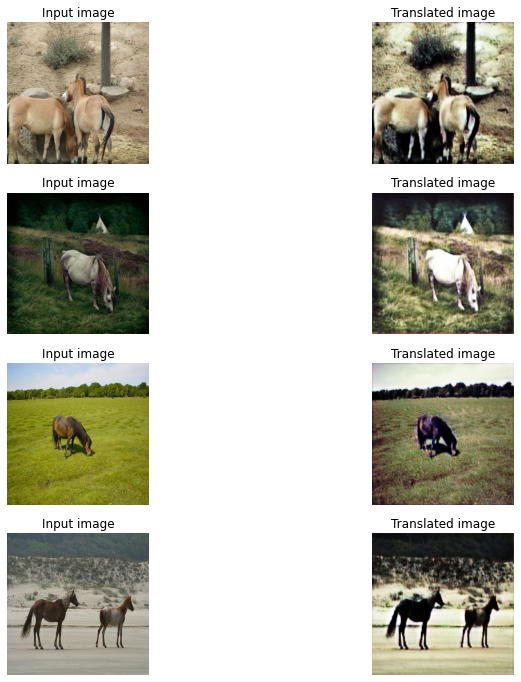

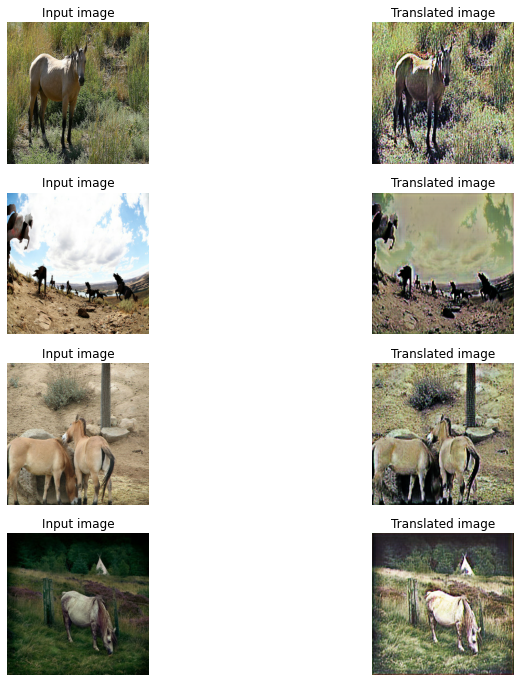

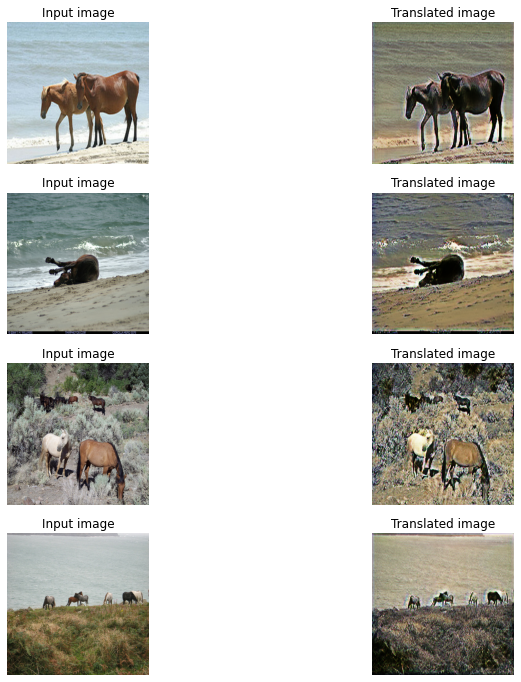

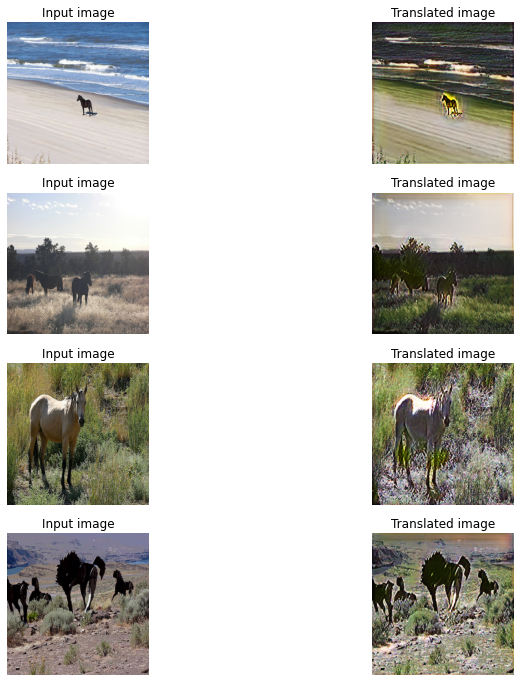

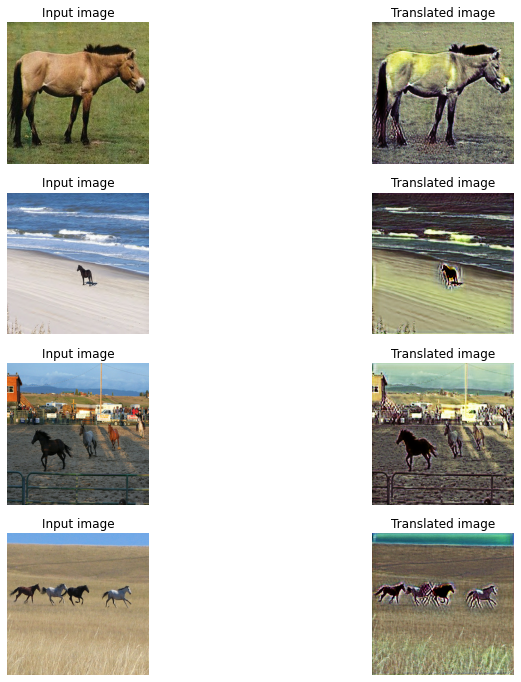

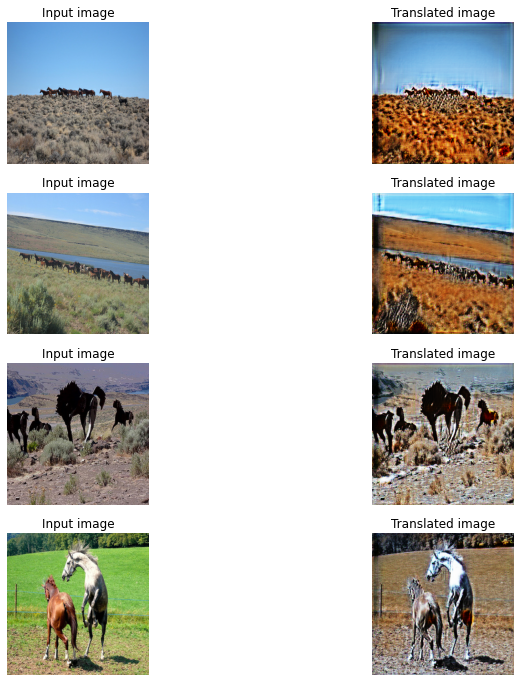

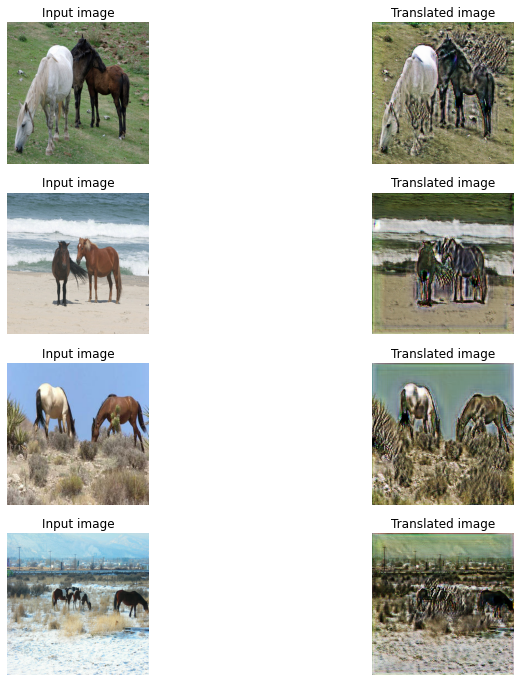

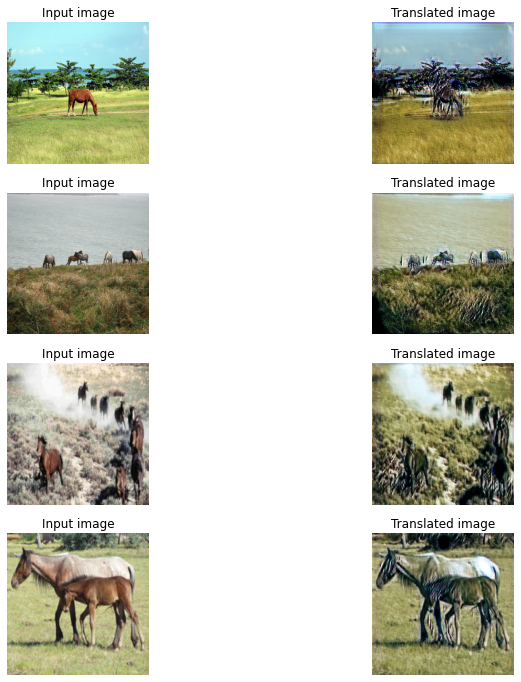

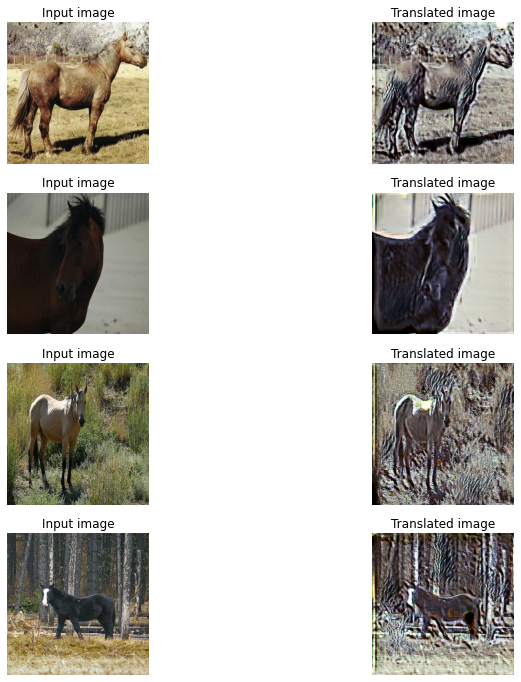

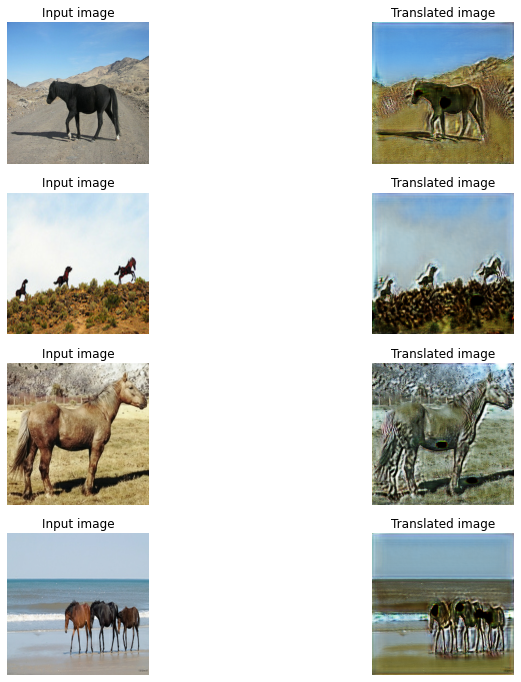

In [13]:
adv_loss_fn = MeanSquaredError()
# Calculate output shape of D (PatchGAN)
patch = int(input_img_size[0] / 2 ** 4)
disc_patch = (patch, patch, 1)

# GAN loss ground truths
real_target = np.ones((batch_size,) + disc_patch)
fake_target = np.zeros((batch_size,) + disc_patch)

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(real_target), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real_target), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake_target), fake)
    return (real_loss + fake_loss) * 0.5

# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y,
            lambda_cycle=10.0,
        lambda_identity=0.5,
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)
# Callbacks
plotter = GANMonitor()
# checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
# model_checkpoint_callback = ModelCheckpoint(
#     filepath=checkpoint_filepath
# )

# Here we will train the model for just one epoch as each epoch takes around
# 7 minutes on a single P100 backed machine.
cycle_gan_model.fit(
    tf.data.Dataset.zip((train_horses, train_zebras)),
    epochs=10,
    callbacks=[plotter],
)